In [1]:
import rom_operator_inference as opinf

import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools

from tqdm.notebook import tqdm
import warnings
from scipy.integrate import IntegrationWarning
from scipy.linalg import LinAlgWarning

In [2]:
# !pip install git+https://github.com/Willcox-Research-Group/rom-operator-inference-Python3.git

In [304]:
# Matplotlib customizations.
plt.rc("figure", dpi=300, figsize=(9,3))
plt.rc("font", family="serif", size=6)
plt.rc("legend", edgecolor='none')

In [3]:
chosen_columns = ['p', 'U:2']  # todo (sanity check) check absolute value other U:0, U:1 (done in 01>data_transform.ipynb)
sets = ['train', 'val', 'test']

input_files = [(dataset, column) for dataset in sets for column in chosen_columns]

In [4]:
input_files

[('train', 'p'),
 ('train', 'U:2'),
 ('val', 'p'),
 ('val', 'U:2'),
 ('test', 'p'),
 ('test', 'U:2')]

In [5]:
tables = {}
for i in input_files:
    with open(f'{i[0]}_{i[1]}.pkl', 'rb') as f:        
        tables[f'{i[0]}_{i[1]}'] = pickle.load(f)

## Plotting the mean pressure and speed

In [6]:
import pandas as pd
v_inlet_bc = pd.read_csv("v_inlet_bc.csv")

In [7]:
tables['train_p']

array([[ 3.5176e+03,  8.0626e+01,  4.2379e+01, ...,  3.4691e+03,
         3.1394e+03,  3.4567e+03],
       [ 4.8551e+02,  5.6927e+00,  3.0672e+00, ...,  4.8197e+02,
         4.3094e+02,  4.8102e+02],
       [ 4.5713e+02,  5.7872e+00,  3.1071e+00, ...,  4.5353e+02,
         4.0197e+02,  4.5255e+02],
       ...,
       [ 2.8777e+00, -1.0637e+00, -5.4266e-01, ...,  3.3313e+00,
        -4.4804e+00,  3.3647e+00],
       [ 2.3595e+00, -1.0542e+00, -5.4202e-01, ...,  2.8224e+00,
        -4.2974e+00,  2.8618e+00],
       [ 8.4368e-01, -1.0536e+00, -5.3081e-01, ...,  1.3165e+00,
        -4.9449e+00,  1.3602e+00]])

In [8]:
tables['train_p'].shape
# todo check if mean is dominant, plot eigen values and eigen vectors of the PCA.
# Plot eigen values see if decrease
# OR plot the sum of eigen values
# if increase the number of eigen values, "energy" is increase s.t we perserve the system

# cumulative e. preservation Sum of eigen / sum of all of eigen


(499, 7582)

In [9]:
DELTA_T = 2e-3 # step of a time
MAX_T = 2

According to the https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/main/docs/content/tutorials/basics.ipynb, the matrix must be `space` $\times$ `time`

In [10]:
for t in tables:
    tables[t] = tables[t].T

In [11]:
assert tables['train_p'].shape[0] > tables['train_p'].shape[1]   # space is larger than time

In [12]:
all_pressures = np.concatenate([tables['train_p'], tables['val_p'], tables['test_p']],axis=1)
all_pressures.shape

(7582, 999)

In [13]:
all_pressures_mean = all_pressures.mean(0)

In [14]:
tables['train_p'].shape

(7582, 499)

In [15]:
all_pressures_mean.shape

(999,)

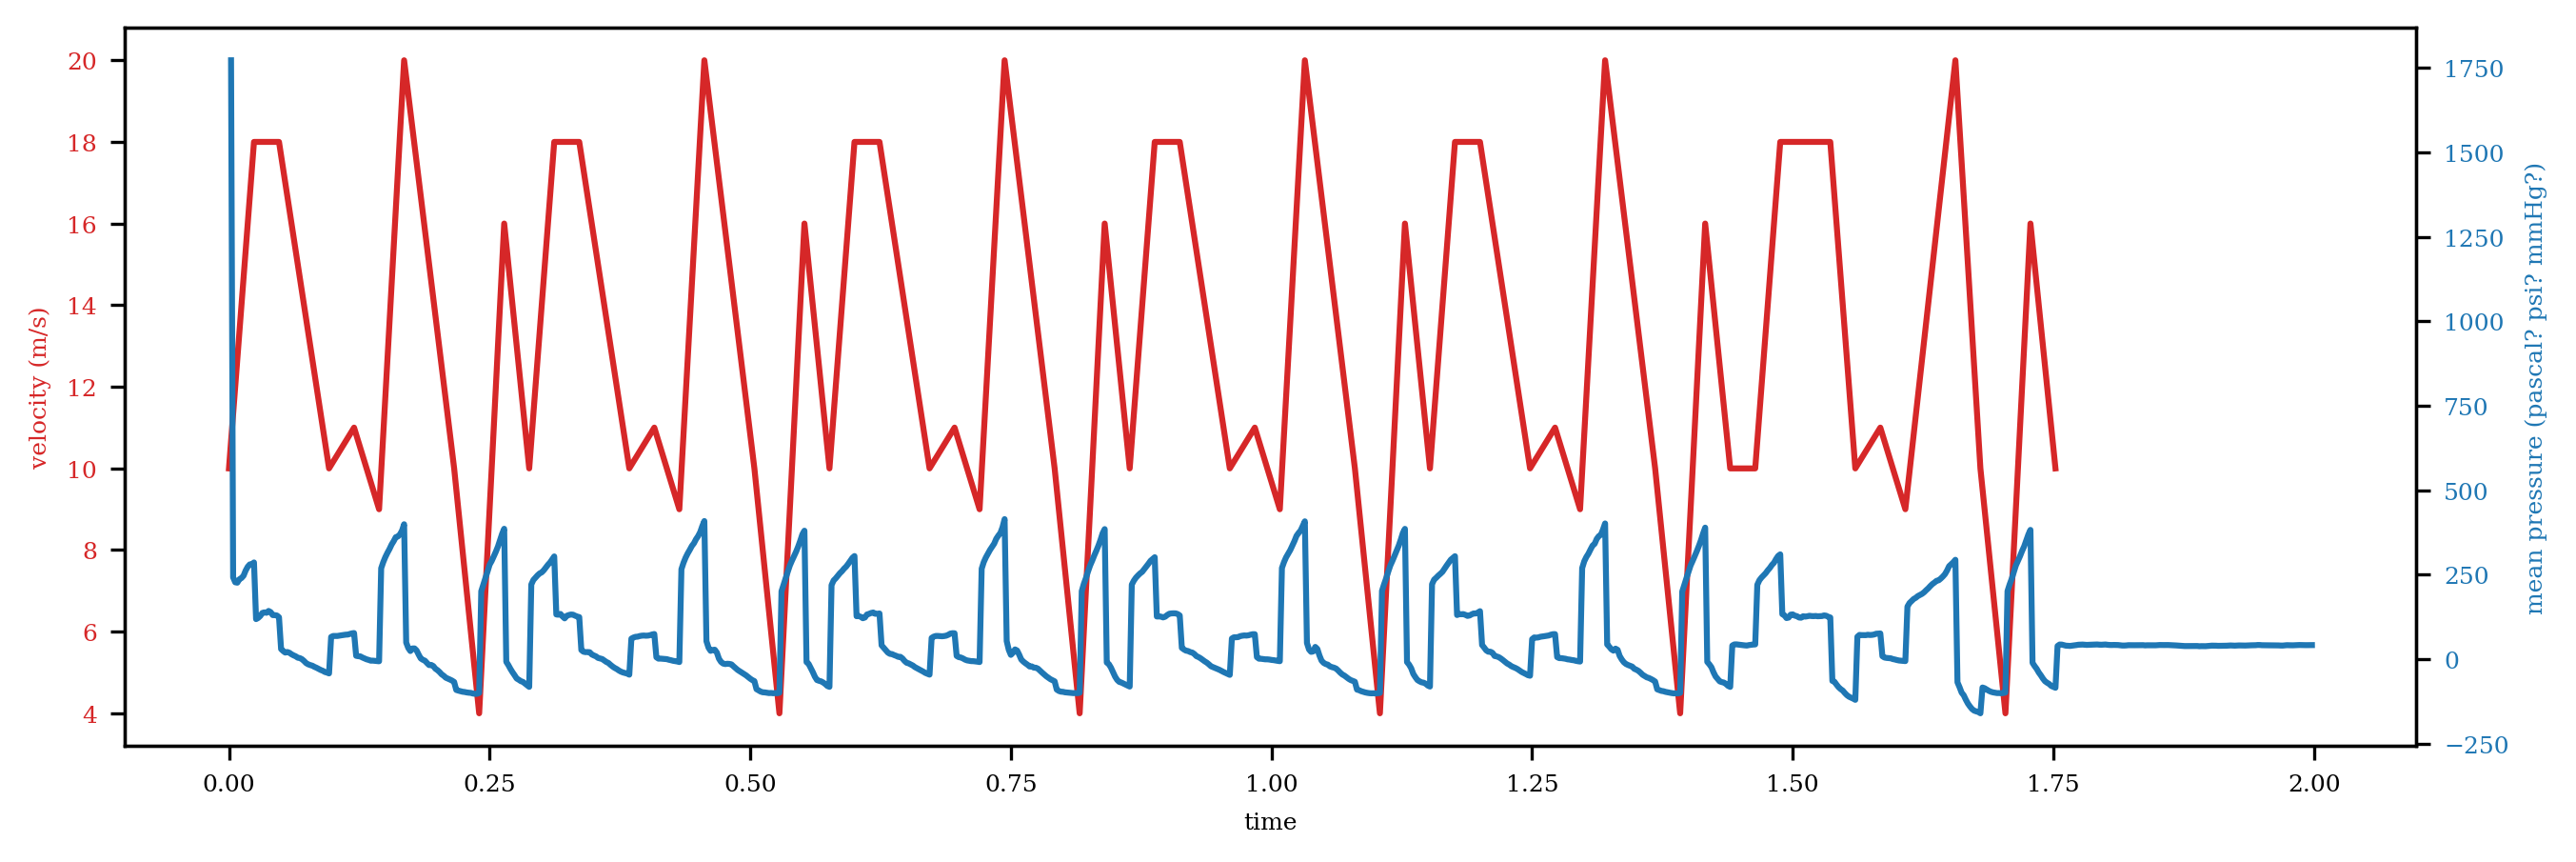

In [305]:
fig, ax1 = plt.subplots()
x1 = np.arange(DELTA_T, MAX_T, DELTA_T)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('velocity (m/s)', color=color)
ax1.plot(v_inlet_bc['t'], v_inlet_bc['Uz'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('mean pressure (pascal? psi? mmHg?)', color=color)
ax2.plot(x1, all_pressures_mean)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# todo ignore the 1st step of data

# for future, BC as a forcing term

Due to the strange outlier in 1st frame of pressure, we will ignore it

In [20]:
# discard the first data point for train
for i in chosen_columns:
    tables[f'train_{i}'] = tables[f'train_{i}'][:,1:]

## Scale and stack data

Scale separately for each feature, s.t they have 0 mean, 1 std. Then stacking `[rho_0, v_0, rho_1, v_1, … , rho_n, v_n]` to a `train_data`. The shape would be (`space` $\times$ `num_ft`, `time`)

$
\begin{bmatrix} p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
p_{m,1} & p_{m,2} & \cdots & p_{m,n} \end{bmatrix}
$
$
\begin{bmatrix} U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ 
U:2_{2,1} & U:2_{2,2} & \cdots & U:2_{1,n} \\ 
\vdots & \vdots & \vdots & \vdots \\ 
U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}
$
$
\rightarrow
$
$
\begin{bmatrix} k_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ nut_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ \omega_{1,1} & \omega_{1,2} & \cdots & \omega_{1,n} \\  p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\  U:0_{1,1} & U:0_{1,2} & \cdots & U:0_{1,n} \\  U:1_{1,1} & U:1_{1,2} & \cdots & U:1_{1,n} \\  U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ \vdots & \vdots & \vdots & \vdots \\ U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}  (1)
$

with $m$ is space and $n$ is time (https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/issues/30)

### Normalize data

In [22]:
def normalize(timeframes, max_ft = None, min_ft = None):
    '''
    At t=0, get the mean and std through spacial dimension
    '''
    if max_ft is not None and min_ft is not None:
        scaled = (timeframes - min_ft) / (max_ft - min_ft)
        return scaled
    max_ft = timeframes.max(1).reshape((timeframes.shape[0], 1))
    min_ft = timeframes.min(1).reshape((timeframes.shape[0], 1))
    for i in range(max_ft.shape[0]):
        if max_ft[i] == min_ft[i]:
            max_ft[i] += 1  # so that (x - min_ft[i]) / (max_ft[i] - min_ft[i]) = (x - min_ft[i]) / 1, to avoid div by 0
    scaled = (timeframes - min_ft) / (max_ft - min_ft)
    return scaled, max_ft, min_ft

In [23]:
# test normalize
data = np.array([[-1. ,  2. ], [-0.5,  6. ], [ 0. , 10. ], [ 1. , 18. ]])
normed_data, max_ft, min_ft = normalize(data)
print(f"{max_ft} \n {min_ft} \n {normed_data}")
print(normalize([[100], [100], [100], [100]], max_ft, min_ft))

[[ 2.]
 [ 6.]
 [10.]
 [18.]] 
 [[-1. ]
 [-0.5]
 [ 0. ]
 [ 1. ]] 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[33.66666667]
 [15.46153846]
 [10.        ]
 [ 5.82352941]]


In [24]:
normed_data, max_ft, min_ft = {}, {}, {}
for key in tables:
    if key.startswith('train'):
        normed_data[key], max_ft[key], min_ft[key] = normalize(tables[key])

### Stack data

In [25]:
def stack_data(tables_to_stack, set_name):
    if set_name not in('train', 'val', 'test'):
        raise ValueError
    data = []
    for row in range(tables_to_stack[f'{set_name}_p'].shape[0]):
        for i in tables_to_stack:
            if i.startswith(set_name):
                data.append(tables_to_stack[i][row])
    data = np.array(data)
    print("After stacking shape: ", data.shape)
    assert len(data) == sum([len(tables_to_stack[t]) for t in tables_to_stack if t.startswith(set_name)])  # train_data long as concat of all tables
    return data

In [26]:
# test stack_data
# tr_p_11: train p at space 1 time 1
test_table = {'train_p': np.array([['tr_p_11', 'tr_p_12'], ['tr_p_21', 'tr_p_22']]), 
              'train_u': np.array([['tr_u_11', 'tr_u_12'], ['tr_u_21', 'tr_u_22']]),
              'val_p': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']]), 
              'val_u': np.array([['va_p_11', 'va_p_12'], ['va_p_21', 'va_p_22']])}
expected_result = np.array([['tr_p_11', 'tr_p_12'], ['tr_u_11', 'tr_u_12'], 
                            ['tr_p_21', 'tr_p_22'], ['tr_u_21', 'tr_u_22']])
assert (stack_data(test_table, 'train') == expected_result).all()
expected_result

After stacking shape:  (4, 2)


array([['tr_p_11', 'tr_p_12'],
       ['tr_u_11', 'tr_u_12'],
       ['tr_p_21', 'tr_p_22'],
       ['tr_u_21', 'tr_u_22']], dtype='<U7')

In [27]:
def unstack_data(array, ft, list_of_fts):
    # find the order $o$ of `ft` in `list_of_fts`
    # then extract every $o$th row, starting from the first $o$th row, not 0
    assert len(array.shape) == 2
    index = list_of_fts.index(ft)
    return array[np.arange(index, array.shape[0], len(list_of_fts)),:]

In [28]:
test_arr = np.array([['u11', 'u12', 'u13'], ['v11', 'v12', 'v13'], ['p11', 'p12', 'p13'], 
                     ['u21', 'u22', 'u23'], ['v21', 'v22', 'v23'], ['p21', 'p22', 'p23']])
assert (unstack_data(test_arr, 'u', ['u', 'v', 'p']) == np.array([['u11', 'u12', 'u13'], ['u21', 'u22', 'u23']])).all()  # a: 1st element, sample every 1
assert (unstack_data(test_arr, 'v', ['u', 'v', 'p']) == np.array([['v11', 'v12', 'v13'], ['v21', 'v22', 'v23']])).all()  # b: 2nd element, sample every 2
assert (unstack_data(test_arr, 'p', ['u', 'v', 'p']) == np.array([['p11', 'p12', 'p13'], ['p21', 'p22', 'p23']])).all()  # c: 3rd element, sample every 3

In [98]:
def prepare_data_and_train(data_to_train, r, regularizer=1e6):
    train_data_derivative = opinf.pre.ddt(data_to_train, DELTA_T, order=6)        # Calculate the time derivative matrix.
    Vr, _ = opinf.pre.pod_basis(data_to_train, r)
    rom = opinf.ContinuousOpInfROM(modelform="cAH")   # todo add quadratics cA is just DMD https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/dad3b6588708c2a4d600491ebd936165a76968ca/src/rom_operator_inference/core/nonparametric/_public.py#L217
    rom.fit(Vr, data_to_train, train_data_derivative, regularizer=regularizer)
    return rom

In [30]:
def post_process(prediction, max_ft, min_ft):
    scaled_predicted_p = unstack_data(prediction, 'p', chosen_columns)
    predicted_p = (scaled_predicted_p * (max_ft - min_ft)) + min_ft
    return predicted_p

### Create train data

In [221]:
# stack data
train_data = stack_data(normed_data, 'train')  # todo no stack yet
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()
    
assert (train_data[0,:] == normed_data['train_p'][0,:]).all()
assert (train_data[1,:] == normed_data['train_U:2'][0,:]).all()

After stacking shape:  (15164, 498)


In [222]:
start_prediction = (tables['train_p'].shape[1] + 1 + 1) * DELTA_T  # 1 for skipping one at the beginning, 1 for the frame after last frame
end_prediction = (tables['train_p'].shape[1] + tables['val_p'].shape[1] + 1 + 1) * DELTA_T
print(start_prediction, end_prediction)

1.0 1.198


In [223]:
tables['val_p'].shape

(7582, 99)

In [224]:
np.arange(start_prediction, end_prediction, DELTA_T).shape

(99,)

### Choosing number of basis

In [225]:
import scipy.linalg as la

svdvals = la.svdvals(train_data)
svdvals

array([1.29108467e+03, 4.51623373e+02, 6.51259498e+01, 4.30985877e+01,
       2.66017140e+01, 2.02739570e+01, 1.87429917e+01, 1.42089322e+01,
       1.38290333e+01, 1.37035344e+01, 1.02992512e+01, 9.75220323e+00,
       8.75346652e+00, 8.43318932e+00, 8.05301345e+00, 7.52729416e+00,
       7.36430181e+00, 6.52940222e+00, 6.14834579e+00, 5.67977961e+00,
       5.55095847e+00, 5.25152970e+00, 5.09036583e+00, 5.05654037e+00,
       4.62411730e+00, 4.39490413e+00, 4.11607097e+00, 4.07519913e+00,
       3.99873499e+00, 3.64102119e+00, 3.54510252e+00, 3.41236381e+00,
       3.36549136e+00, 3.33042339e+00, 3.04415320e+00, 3.00201474e+00,
       2.98619561e+00, 2.89100894e+00, 2.74401264e+00, 2.68032144e+00,
       2.65385429e+00, 2.60371527e+00, 2.47351285e+00, 2.41819530e+00,
       2.36558879e+00, 2.35238033e+00, 2.24212338e+00, 2.18869025e+00,
       2.18152208e+00, 2.10627049e+00, 2.07987703e+00, 2.04979036e+00,
       1.98303134e+00, 1.96244956e+00, 1.90623194e+00, 1.85272020e+00,
      

498

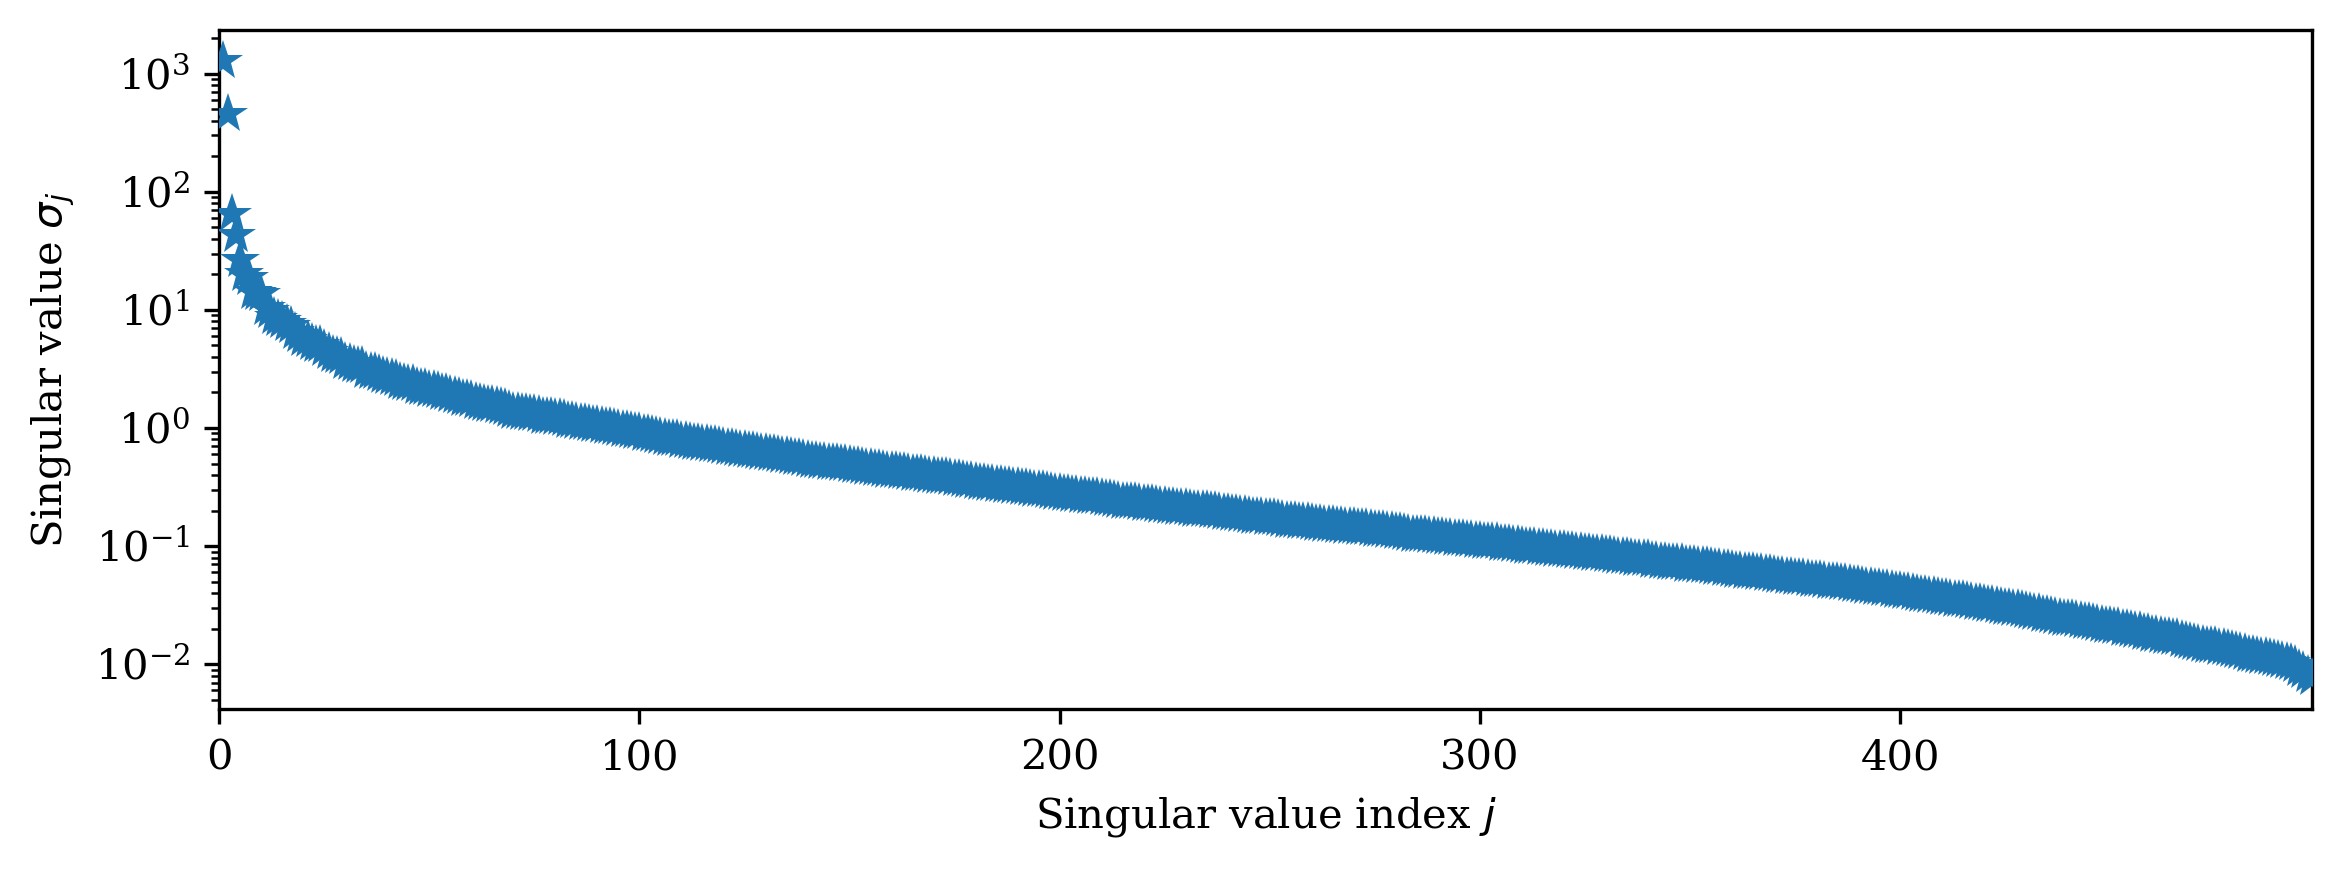

In [226]:
opinf.pre.svdval_decay(svdvals, 1e-3, plot=True)

In [227]:
r = opinf.pre.cumulative_energy(svdvals, .999, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9996, plot=False)
print(f"r = {r}")
r = opinf.pre.cumulative_energy(svdvals, .9999, plot=False)
print(f"r = {r}")

r = 7
r = 15
r = 40


Fitting `r` as 15

In [279]:
r = 15
Vr, _ = opinf.pre.pod_basis(train_data, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (15164, 15)


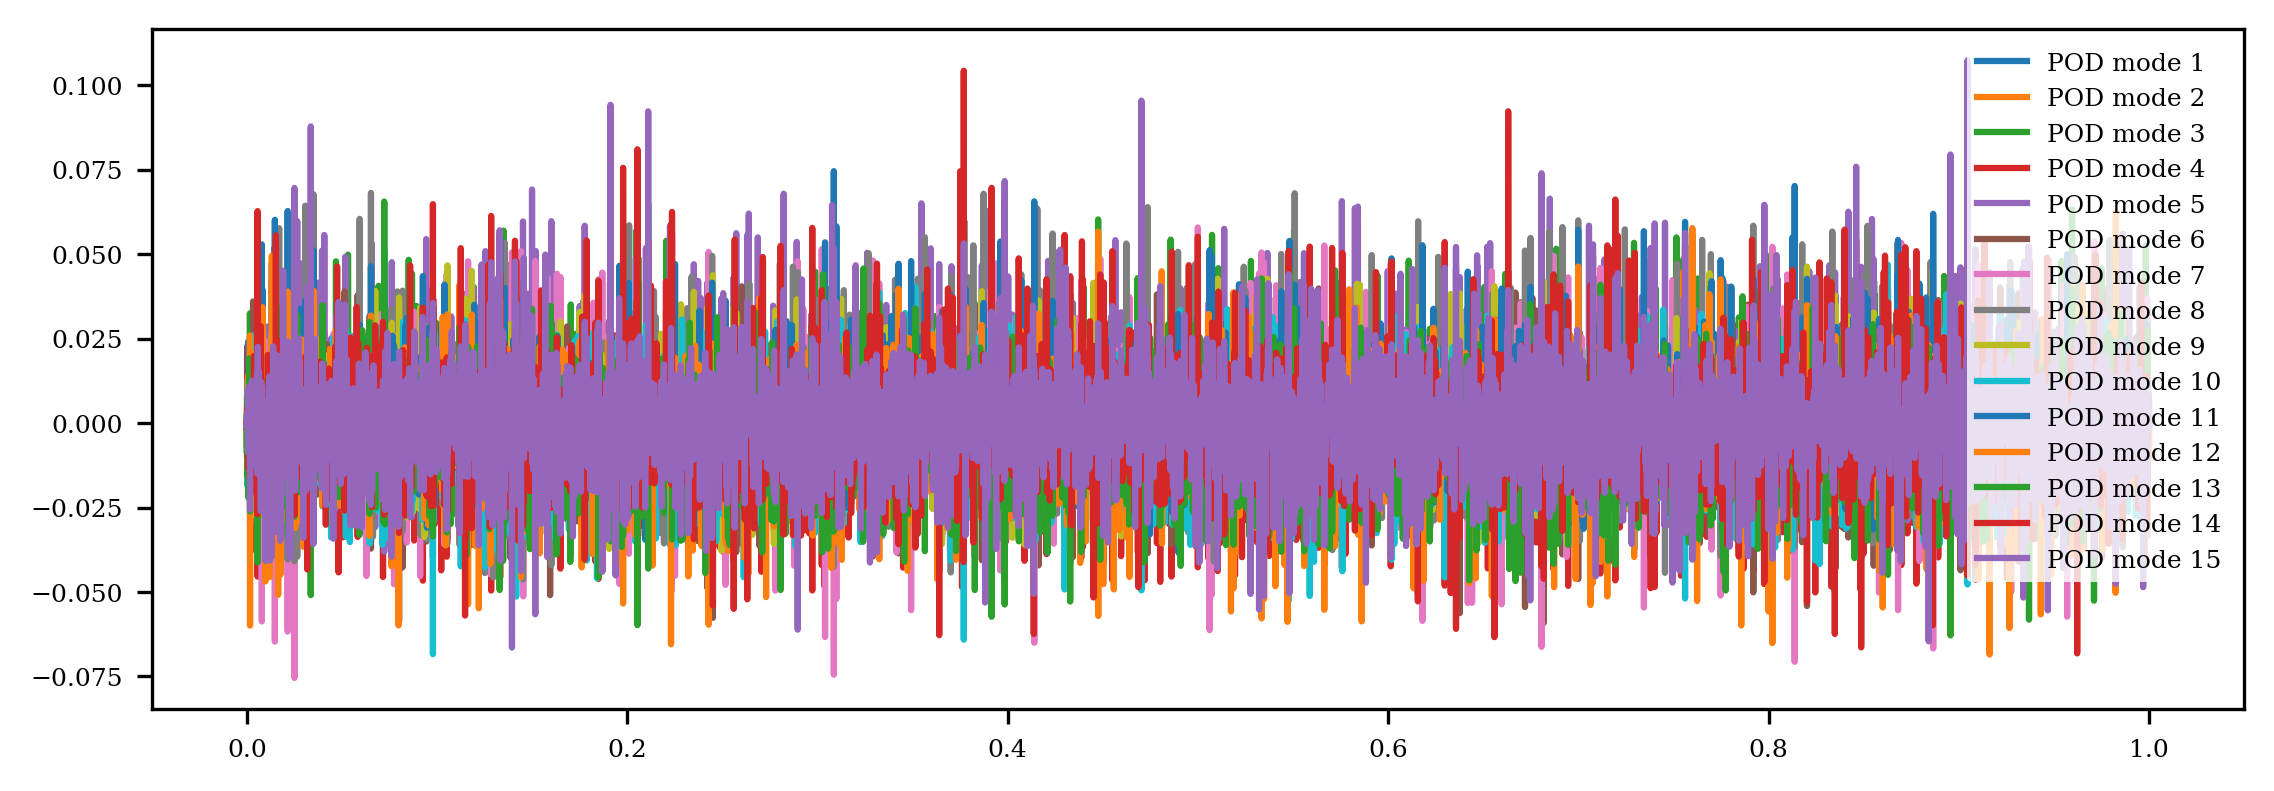

In [306]:
# Visualize those pod
for j in range(Vr.shape[1]):    
    plt.plot(np.linspace(0, 1, Vr.shape[0]+2), np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()

In [324]:
def train_and_plot(regularizer_range, r):
    regularizers, val_losses, train_losses = [], [], []
    for regularizer in tqdm(regularizer_range):
        rom = prepare_data_and_train(train_data, r=r, regularizer=regularizer)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                prediction = rom.predict(train_data[:,-1], np.arange(start_prediction, end_prediction, DELTA_T), method='Radau')   # predict from the last column of train data        
                # prediction is for multiple variable in chosen_colums. We only care about `p`. 
                # Therefore we are going to extract p from it
                predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
                val_loss = mse(predicted_p , tables['val_p'], squared=False)   
                sanity_check = rom.predict(train_data[:,0], np.arange(DELTA_T, start_prediction- DELTA_T, DELTA_T))
                sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])
                train_loss = mse(sanity_check , tables['train_p'], squared=False)
                print(regularizer, val_loss, train_loss)
                regularizers.append(regularizer)
                val_losses.append(val_loss)
                train_losses.append(train_loss)
            except IntegrationWarning:
                print(f'regularizer={regularizer}, integration error happens')
            except LinAlgWarning:
                print(f'regularizer={regularizer}, unterdetermined system')
    return regularizers, train_losses, val_losses

In [325]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(1e3, 5e4), 15)

  0%|          | 0/50 [00:00<?, ?it/s]

1000.0 272.6159405629088 531.8763045131401
2000.0 226.37685539106204 191.14914247289954
3000.0 209.6391920958572 171.65462386815005
4000.0 201.99302028569585 164.11956062991953
5000.0 207.75389565720994 165.5192139392763
6000.0 219.248170389437 174.27104626800596
7000.0 230.00190764414486 179.51505678779026
8000.0 238.52485548934774 192.1385471670106
9000.0 244.56902618862546 203.83371651885082
10000.0 249.01266157529528 207.83290891778304
11000.0 252.4630767866152 212.7956721700726
12000.0 255.3943948697123 222.29477995247063
13000.0 258.02435411462756 230.40504649547242
14000.0 260.2532875975524 245.708412499938
15000.0 262.03785832941446 260.26351532314305
16000.0 263.4550936877618 269.43243503951373
17000.0 264.56184161386386 275.9074935171714
18000.0 265.40533138602416 280.8885825036022
19000.0 266.02208778460977 285.0156248743359
20000.0 266.441643500066 288.6166811260131
21000.0 266.68669899696755 291.880873875597
22000.0 266.781375533379 294.91812526627524
23000.0 266.741274217

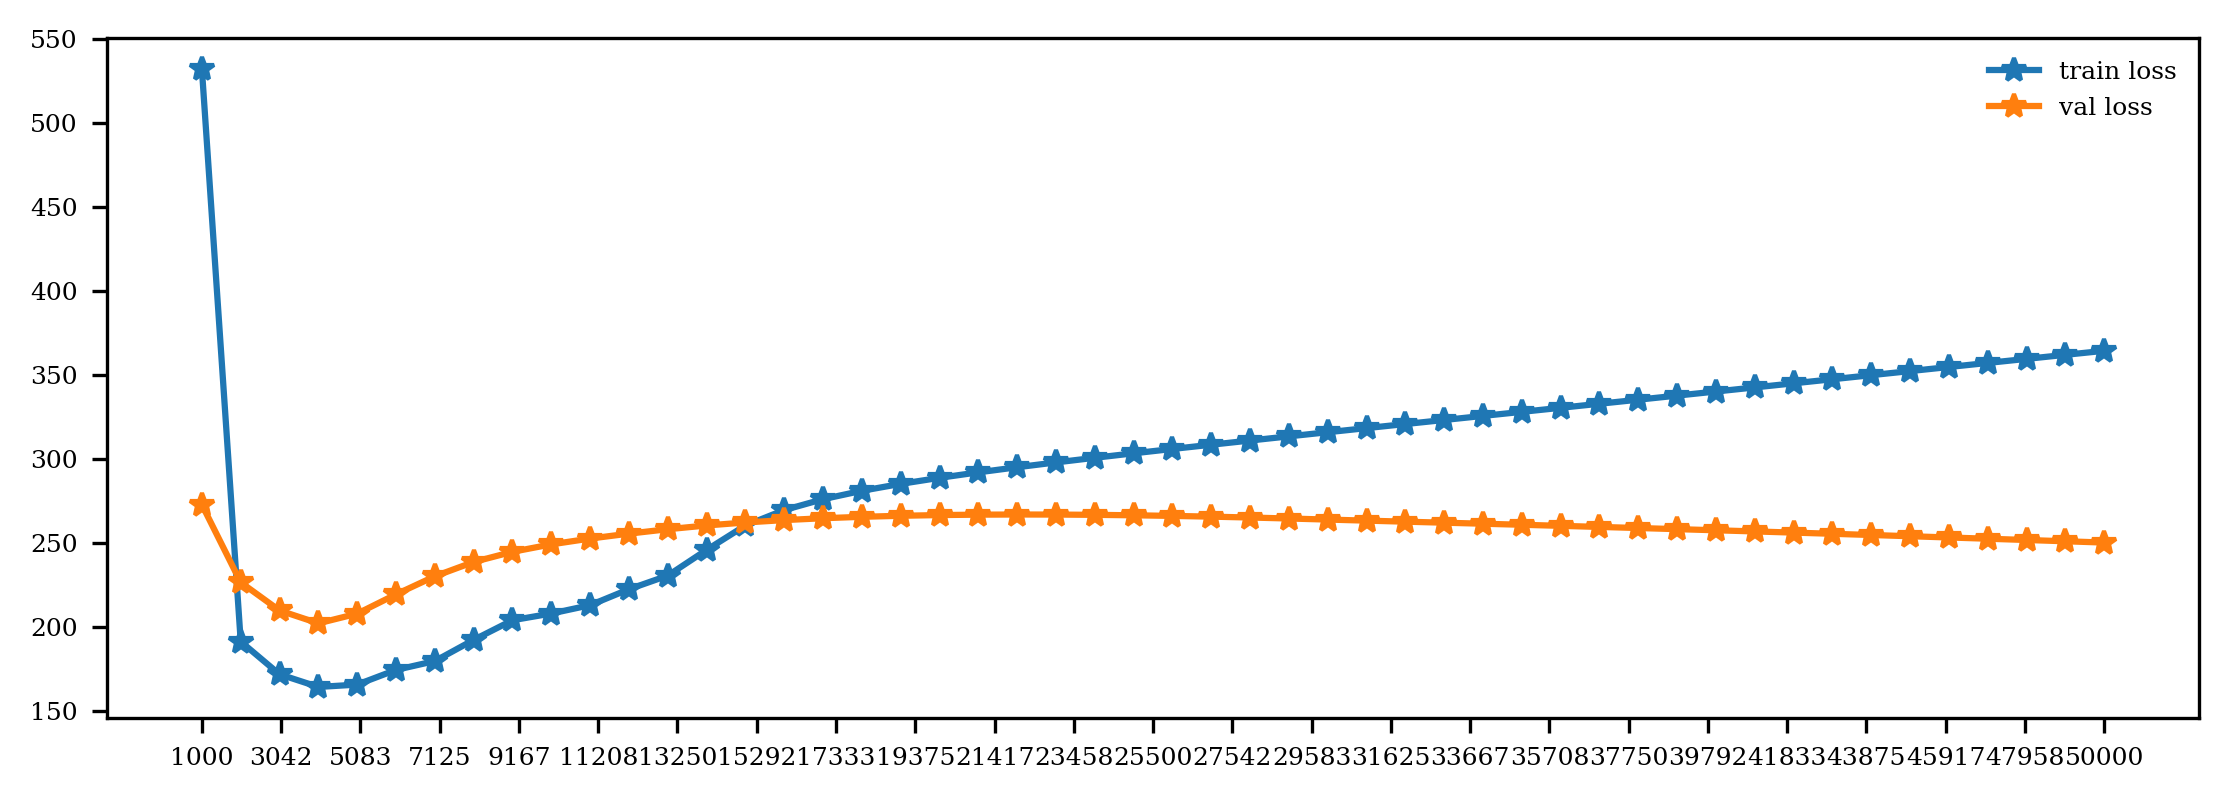

In [315]:
def losses_plot(x, train_loss, val_loss):
    fig, ax = plt.subplots()
    plt.plot(regularizers, train_losses, '-*', label='train loss')
    plt.plot(regularizers, val_losses, '-*', label='val loss')
    plt.xticks(np.linspace(regularizers[0], regularizers[-1], 25))
    plt.legend()
    plt.show()
    
losses_plot(regularizers, train_loss, val_loss)

Between 2nd and 4th are sweet spot. I will zoom into this

In [326]:
regularizers, train_losses, val_losses = train_and_plot(np.linspace(3e3, 5e3), 15)

  0%|          | 0/50 [00:00<?, ?it/s]

3000.0 209.6391920958572 171.65462386815005
3040.816326530612 209.39011508498913 170.50176225876757
3081.6326530612246 209.11623515187185 169.81414124533882
3122.4489795918366 208.8190928867744 168.88372223796276
3163.265306122449 208.5008454067844 168.0925444117461
3204.081632653061 208.16673558326156 167.6249949291365
3244.8979591836733 207.82114921557965 167.32370320576354
3285.714285714286 207.46597597654832 166.86302352450858
3326.530612244898 207.10329119799297 165.90726413203683
3367.3469387755104 206.73222369419278 164.74261838932497
3408.1632653061224 206.354595913276 164.42323806027727
3448.9795918367345 205.9739239786405 164.09021465872925
3489.795918367347 205.59227655830458 163.1712344910014
3530.612244897959 205.21383883702845 161.71487222868708
3571.4285714285716 204.84136564823694 160.25275381671005
3612.2448979591836 204.47897633622716 159.1678013690615
3653.0612244897957 204.12956529838132 158.4313283839648
3693.877551020408 203.79550685795263 158.30344742932527
3734.

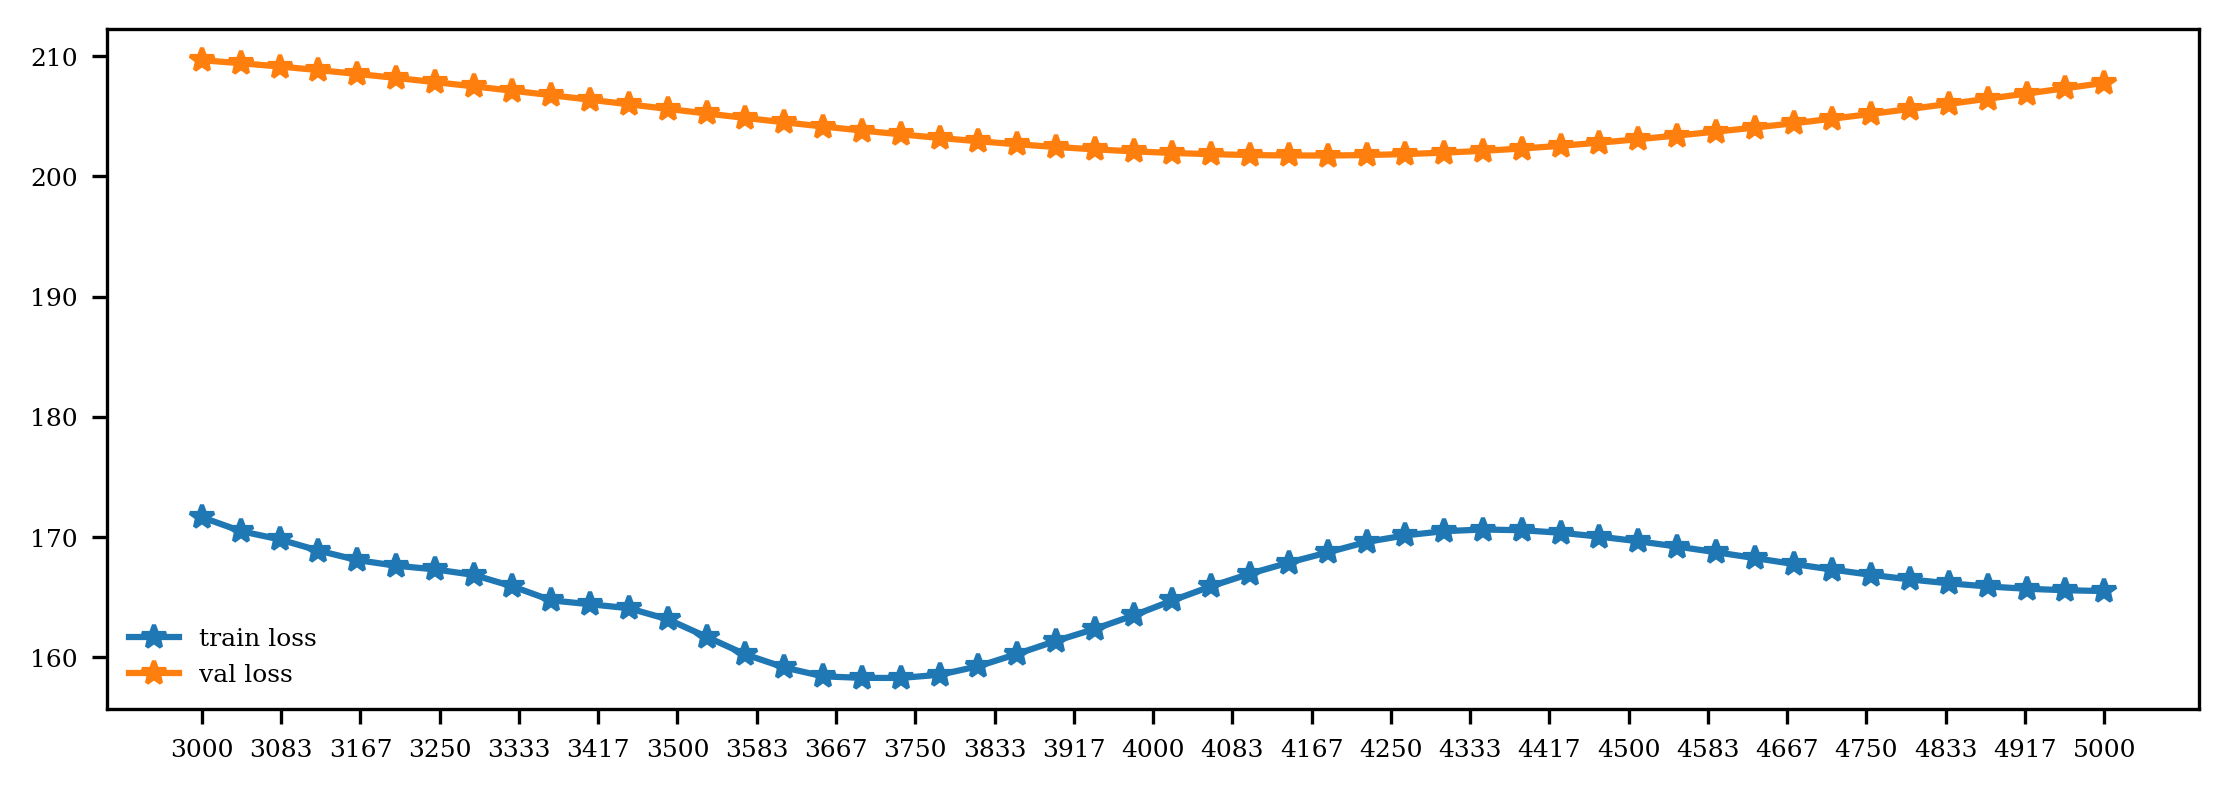

In [327]:
losses_plot(regularizers, train_loss, val_loss)

In [323]:
np.argmin(val_losses), np.min(val_losses), regularizers[np.argmin(val_losses)]

(29, 201.71884028821677, 4183.673469387755)

In [328]:
def plot_pred(groundtruth, prediction):
    plt.plot(range(groundtruth.shape[1]), groundtruth.mean(0))
    plt.plot(range(groundtruth.shape[1]), prediction.mean(0), alpha=0.5)
    plt.legend(["groundtruth", "prediction"])

### Plotting again with best params

In [329]:
rom = prepare_data_and_train(train_data, r=r, regularizer=regularizers[np.argmin(val_losses)])
prediction = rom.predict(train_data[:,-1], np.arange(start_prediction, end_prediction, DELTA_T), method='Radau')   # predict from the last column of train data        
predicted_p = post_process(prediction, max_ft['train_p'], min_ft['train_p'])
sanity_check = rom.predict(train_data[:,0], np.arange(DELTA_T, start_prediction- DELTA_T, DELTA_T))
sanity_check = post_process(sanity_check, max_ft['train_p'], min_ft['train_p'])

In [332]:
mse(sanity_check , tables['train_p'], squared=False), mse(tables['val_p'], predicted_p, squared=False)

(168.73394113815039, 201.71884028821677)

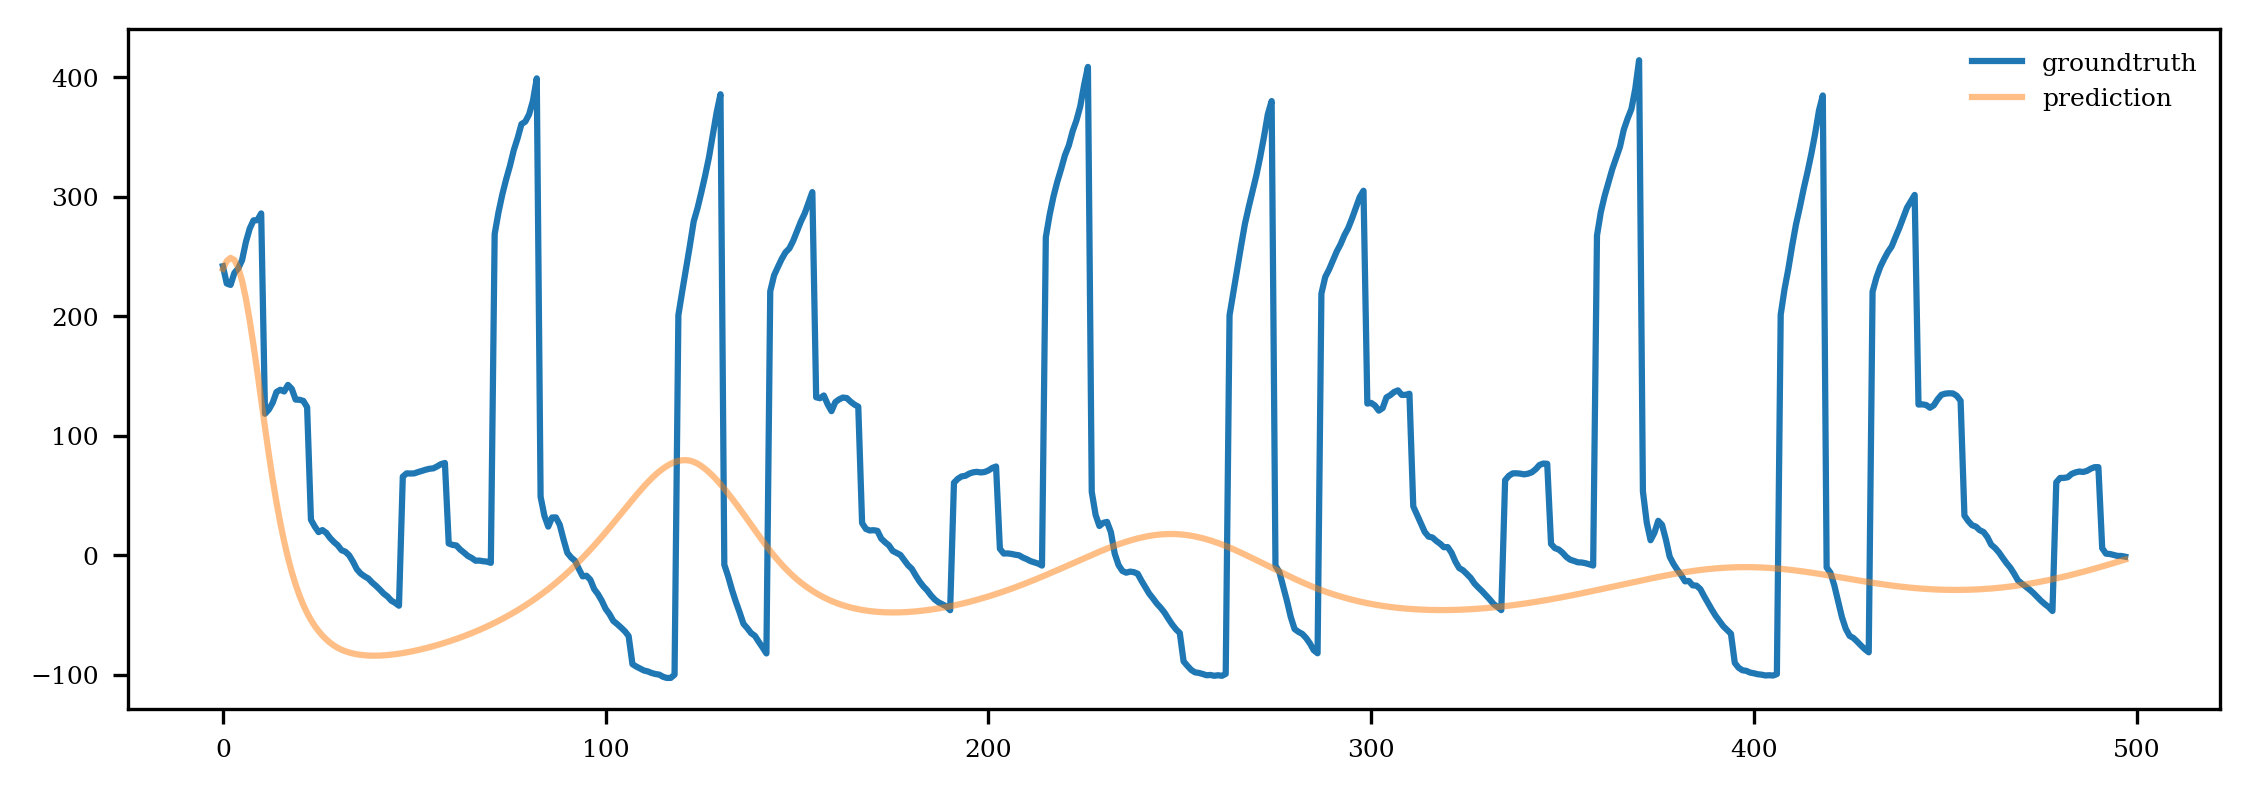

In [330]:
plot_pred(tables['train_p'], sanity_check)

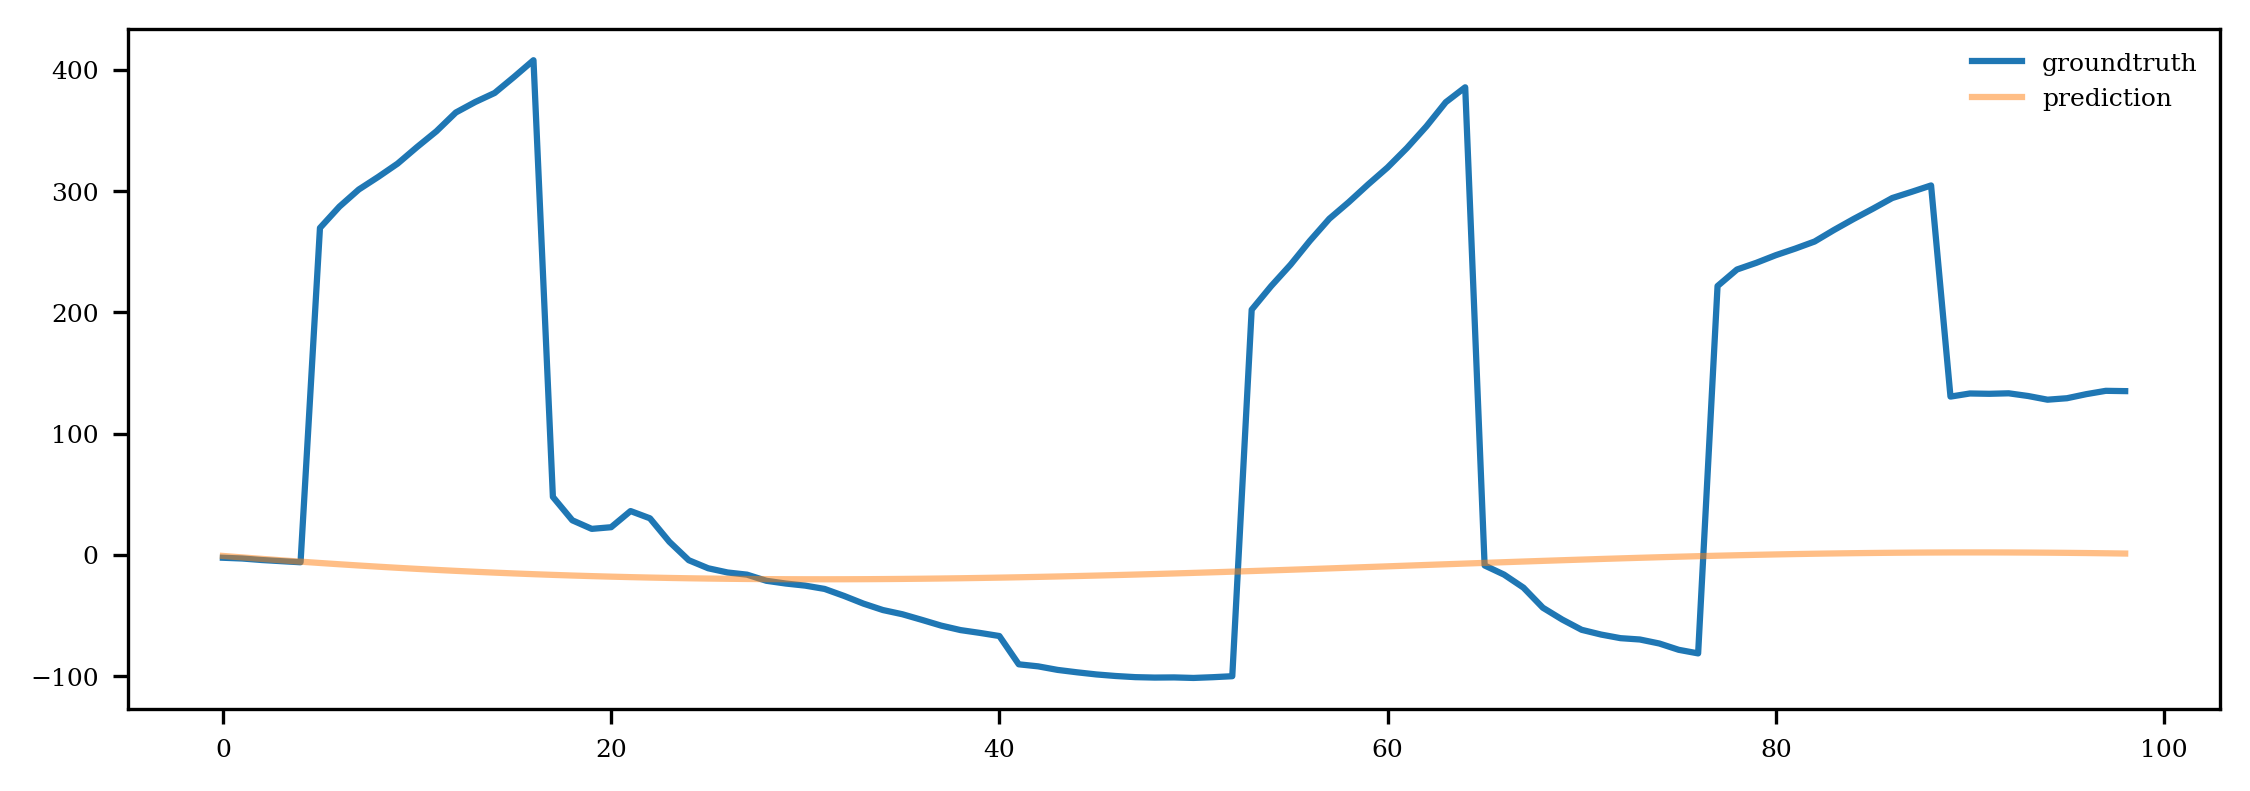

In [331]:
plot_pred(tables['val_p'], predicted_p)

## Train on train, val, and predict test

In [ ]:
# Stack train, val and normalize
# concat train set with val set
train_data_dict = {}
for column in chosen_columns:
    train_data_dict[f'train_{column}'] = np.concatenate((tables[f'train_{column}'], tables[f'val_{column}']), axis=1)

In [ ]:
# normalize each features 
normed_data, means, stds = {}, {}, {}
for key in train_data_dict:
    if key.startswith('train'):
        normed_data[key], means[key], stds[key] = normalize(train_data_dict[key])

In [ ]:
# stack data
train_data = stack_data(normed_data, 'train')

In [ ]:
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()

In [ ]:
assert (train_data[0,:] == normed_data['train_p'][0,:]).all()
assert (train_data[1,:] == normed_data['train_U:2'][0,:]).all()

In [ ]:
# train 
rom = prepare_data_and_train(train_data, best_basis, best_reg)

# predict
prediction = rom.predict(train_data[:,-1], np.arange(0.0598, 0.0999, 1e-4), method='Radau')   # predict from the last column of val data
predicted_p = post_process(prediction, means['train_p'], stds['train_p'])

tmp = mse(predicted_p, tables['test_p'], squared=False)

In [ ]:
tmp  # 455.61986895953567   478.81477974255034    483.8987597939727

In [ ]:
plot_pred(tables['test_p'], predicted_p)

In [ ]:
# test PCA (with same number of base) on test data to check distribution shift